<a id="title_ID"></a>
# JWST Pipeline Validation Testing Notebook: spec2, msa_flagging step

<span style="color:red"> **Instruments Affected**</span>: NIRSpec 

Tested on CV3 data

### Table of Contents
<div style="text-align: left"> 

<br> [Imports](#imports_ID) <br> [Introduction](#intro_ID) <br> [Testing Data Set](#data_ID) <br> [Run the JWST pipeline and msa_flagging validation tests](#pipeline_ID): [MOS test](#MOS), [IFU test](#IFU) <br> [About This Notebook](#about_ID)<br> [Results](#results) <br>

</div>

<a id="imports_ID"></a>
# Imports
The library imports relevant to this notebook are aready taken care of by importing the NIRSpec PTT.

* os for filepaths
* subprocess for installing PTT and moving output files
* astropy.io for opening fits files
* jwst.msaflagopen.msaflagopen_step is the pipeline step being tested

NOTE: This notebook assumes that the pipeline version to be tested is already installed and its environment is activated.

To be able to run this notebook you need to install PTT (https://github.com/spacetelescope/nirspec_pipe_testing_tool). 

If all goes well you will be able to import PTT.

[Top of Page](#title_ID)

In [1]:
import os
import subprocess
from glob import glob

import jwst
from jwst.pipeline.calwebb_detector1 import Detector1Pipeline
from jwst.assign_wcs.assign_wcs_step import AssignWcsStep
from jwst.msaflagopen.msaflagopen_step import MSAFlagOpenStep
from jwst import datamodels

# The latest version of NPTT is installed in the requirements text file at:
# /jwst_validation_notebooks/environment.yml

# import NPTT
import nirspec_pipe_testing_tool as nptt

# To get data from Artifactory
from ci_watson.artifactory_helpers import get_bigdata


In [2]:
# VERSIONS

# print the jwst pipeline version
print("Using JWST pipeline version: ", jwst.__version__)

# Make sure that the version used is the right one

# to get the latest version from 'master' run:
# subprocess.run(['pip', 'install', 'git+https://github.com/spacetelescope/nirspec_pipe_testing_tool@master'])

latest_nptt_stable_version = '1.1.4'
nptt_version = nptt.__version__

if nptt_version != latest_nptt_stable_version:
    print("\n* WARNING - The code might break because the version used is not the latest stable version:")
    print("            Latest stable version is ", latest_nptt_stable_version)
    print("            Using NPTT version ", nptt_version)

Using JWST pipeline version:  0.18.2.dev3+g69f9c4f4

* WARNING - The code might break because the version used is not the latest stable version:
            Latest stable version is  1.1.4
            Using NPTT version  1.1.3


<a id="intro_ID"></a>
# Test Description

The test is a comparison of the result of our implementation of the MSA Failed Open Flagging step algorithm versus the pipeline's implementation.

The overlap between the pixels flagged as being affected by failed open shutters are compared in regions large enough in the spectral direction to account for the non-repeatable motion of the grating wheel (a few pixels).

For the test to be considered PASSED, the overlap between the results of the two methods should be greater than or equal to msa_flagging_threshold percent for all failed open shutters affecting more than 100 pixels.

The code for these Multi Object Spectroscopy (MOS) and Integral Field Unit (IFU) tests can be obtained from: https://github.com/spacetelescope/nirspec_pipe_testing_tool/blob/master/nirspec_pipe_testing_tool/calwebb_spec2_pytests/auxiliary_code/msa_flagging_testing.py. This pipeline step and the associated pytests are skipped if data is Fixed Slits (FS) or Bright Object Time Series (BOTS).

The input file is defined in the variable ```input_file``` (see section [Testing Data Set and Variable Setup](#data_ID)).

Step description: https://jwst-pipeline.readthedocs.io/en/latest/jwst/msaflagopen/index.html

Pipeline code: https://github.com/spacetelescope/jwst/tree/master/jwst/msaflagopen


### Results

If the test **PASSED** this means that all slitlets or slices individually passed the test. However, if ony one individual slitlet (for MOS data) or slice (for IFU data) test failed, the whole test will be reported as **FAILED**.


### Calibration WG Requested Algorithm: 

A short description and link to the page: https://outerspace.stsci.edu/display/JWSTCC/Vanilla+MSA+Failed+Open+Flagging


### Defining Terms
Acronymns used in this notebook:

pipeline: calibration pipeline

spec2: spectroscopic calibration pipeline level 2b

PTT: NIRSpec pipeline testing tool


[Top of Page](#title_ID)

<a id="pipeline_ID"></a>
# Run the JWST pipeline and msa_flagging validation tests

The pipeline can be run from the command line in two variants: full or per step.

To run the spec2 pipeline in full use the command: 

$ strun jwst.pipeline.Spec2Pipeline jwtest_rate.fits

where jwtest_rate.fits is the output of cal_detector1.

To only run the msa_flagging step, use the command:

$ strun jwst.msaflagopen.msaflagopen_step jwtest_assign_wcs.fits

where jwtest_assign_wcs.fits is the output of the previous step, assign_wcs.

NIRSpec TA data will be run through the cal_detector1 and the imaging2 pipelines. The imaging pipeline can be run with the following command:

$ strun jwst.pipeline.Image2Pipeline jwtest_rate.fits

These options are also callable from a script with the testing environment active. The Python call for running the pipeline in full or by step are:

$\gt$ from jwst.pipeline.calwebb_spec2 import Spec2Pipeline

$\gt$ Spec2Pipeline.call(jwtest_rate.fits)
 
or
 
$\gt$ from jwst.msaflagopen.msaflagopen_step import msaflagopen_step
 
$\gt$ msaflagopen_step.call(jwtest_rate.fits)

For the imaging pipeline the call would be as follows:

$\gt$ from jwst.pipeline.calwebb_image2 import Image2Pipeline

$\gt$ Image2Pipeline.call(jwtest_rate.fits)

PTT can run the spec2 pipeline either in full or per step, as well as the imaging pipeline in full. In this notebook we will use PTT to run the pipeline and the validation tests.

To run PTT you first need to create and edit the file that controls the tool. This configuration file tells PTT which data to test, the mode, and where to put results and plots, among other variables that can be modified from the default values (e.g. paths for the flat field reference files, acceptance threshold values for differences between pipeline product and benchmark files, modify a benchmark file, etc).

[Top of Page](#title_ID)

<a id="data_ID"></a>
# Testing Data Set

All testing data is from the CV3 campaign. We chose these files because this is our most complete data set, i.e. all modes and filter-grating combinations.

Data used for testing:
- MOS_G140M_LINE1
- MOS_PRISM_CLEAR
- IFU_G395H_F290LP
- IFU_PRISM_CLEAR


[Top of Page](#title_ID)

In [3]:
testing_data = {                
                'mos_prism_clear':{
                                  'uncal_file_nrs1': 'mos_prism_nrs1_uncal.fits',
                                  'uncal_file_nrs2': 'mos_prism_nrs2_uncal.fits',
                                  'msa_shutter_config': 'V0030006000104_msa.fits' },
                
                'mos_g140m_f100lp':{
                                  'uncal_file_nrs1': 'mos_g140m_line1_NRS1_uncal.fits',
                                  'uncal_file_nrs2': 'mos_g140m_line1_NRS2_uncal.fits',  
                                  'msa_shutter_config': 'V8460001000101_msa.fits' },
                
                'ifu_prism_clear':{
                                  'uncal_file_nrs1': 'ifu_prism_nrs1_uncal.fits',
                                  'uncal_file_nrs2': 'ifu_prism_nrs2_uncal.fits',
                                  'msa_shutter_config': None },

                'ifu_g395h_f290lp':{
                                  'uncal_file_nrs1': 'ifu_g395h_f290lp_nrs1_uncal.fits',
                                  'uncal_file_nrs2': 'ifu_g395h_f290lp_nrs2_uncal.fits',
                                  'msa_shutter_config': None }

               }



In [4]:
# define function to pull data from Artifactory
def get_artifactory_file(data_set_dict, detector):
    """This function creates a list with all the files needed per detector to run the test.
    Args:
        data_set_dict: dictionary, contains inputs for a specific mode and configuration
        detector: string, either nrs1 or nrs2
    Returns:
        data: list, contains all files needed to run test
    """
    files2obtain = ['uncal_file_nrs1', 'msa_shutter_config']
    data = []
    for file in files2obtain:
        data_file = None
        try: 
            if '_nrs' in file and '2' in detector:
                file = file.replace('_nrs1', '_nrs2')

            data_file = get_bigdata('jwst_validation_notebooks',
                                         'validation_data',
                                         'nirspec_data', 
                                         data_set_dict[file])
        except TypeError:
            data.append(None)
            continue

        data.append(data_file)

    return data

Testing files for detector:  nrs1
Working with uncal_file:  /Users/pena/Documents/NIRSpec_projects/pipeline_testing_notebooks/jwst_validation_notebooks/jwst_validation_notebooks/msa_flagging/jwst_msa_flagging_nirspec_test/mos_prism_nrs1_uncal.fits


2021-01-22 17:01:11,685 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.
2021-01-22 17:01:11,687 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.
2021-01-22 17:01:11,688 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.
2021-01-22 17:01:11,689 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.
2021-01-22 17:01:11,690 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.
2021-01-22 17:01:11,691 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.
2021-01-22 17:01:11,693 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.
2021-01-22 17:01:11,694 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.
2021-01-22 17:01:11,695 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.
2021-01-22 17:01:11,696 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.
2021-01-22 1

2021-01-22 17:01:11,874 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.
2021-01-22 17:01:11,874 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/Users/pena/crds_cache/references/jwst/nirspec/jwst_nirspec_readnoise_0018.fits'.
2021-01-22 17:01:11,875 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is '/Users/pena/crds_cache/references/jwst/nirspec/jwst_nirspec_refpix_0022.fits'.
2021-01-22 17:01:11,876 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.
2021-01-22 17:01:11,876 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is 'N/A'.
2021-01-22 17:01:11,877 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/Users/pena/crds_cache/references/jwst/nirspec/jwst_nirspec_saturation_0020.fits'.
2021-01-22 17:01:11,877 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is '/Users/pena/crds_cache/references/jwst

2021-01-22 17:01:14,033 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias done
2021-01-22 17:01:14,114 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(1, 4, 3200, 2048) from mos_prism_nrs1_uncal.fits>,).
2021-01-22 17:01:14,116 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/pena/Documents/NIRSpec_projects/pipeline_testing_notebooks/jwst_validation_notebooks/jwst_validation_notebooks/msa_flagging/jwst_msa_flagging_nirspec_test', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}
2021-01-22 17:01:14,127 - stpipe.Detector1Pipeline.refpix - INFO - Using refpix reference file: /Users/pena/crds_ca

2021-01-22 17:01:40,834 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1
2021-01-22 17:01:40,835 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done
2021-01-22 17:01:40,848 - stpipe.AssignWcsStep - INFO - AssignWcsStep instance created.
2021-01-22 17:01:40,939 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep running with args (<ImageModel(2048, 2048) from mos_prism_nrs1_uncal.fits>,).
2021-01-22 17:01:40,940 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}
2021-01-22 17:01:40,984 - stpipe.AssignWcsStep - INFO - 

N/A


2021-01-22 17:01:41,497 - stpipe.AssignWcsStep - INFO - Slits projected on detector NRS1: [3, 4]
2021-01-22 17:01:41,498 - stpipe.AssignWcsStep - INFO - Computing WCS for 2 open slitlets
2021-01-22 17:01:41,521 - stpipe.AssignWcsStep - INFO - gwa_ytilt is 0.0332140289247036 deg
2021-01-22 17:01:41,522 - stpipe.AssignWcsStep - INFO - gwa_xtilt is 0.3367482721805573 deg
2021-01-22 17:01:41,523 - stpipe.AssignWcsStep - INFO - theta_y correction: -1.0907214098475986e-05 deg
2021-01-22 17:01:41,524 - stpipe.AssignWcsStep - INFO - theta_x correction: 0.0 deg
2021-01-22 17:01:41,553 - stpipe.AssignWcsStep - INFO - SPORDER= 0, wrange=[6e-07, 5.3e-06]
2021-01-22 17:01:41,769 - stpipe.AssignWcsStep - INFO - There are 0 open slits in quadrant 1
2021-01-22 17:01:41,770 - stpipe.AssignWcsStep - INFO - There are 0 open slits in quadrant 2
2021-01-22 17:01:41,770 - stpipe.AssignWcsStep - INFO - There are 1 open slits in quadrant 3
2021-01-22 17:01:41,784 - stpipe.AssignWcsStep - INFO - There are 1 op

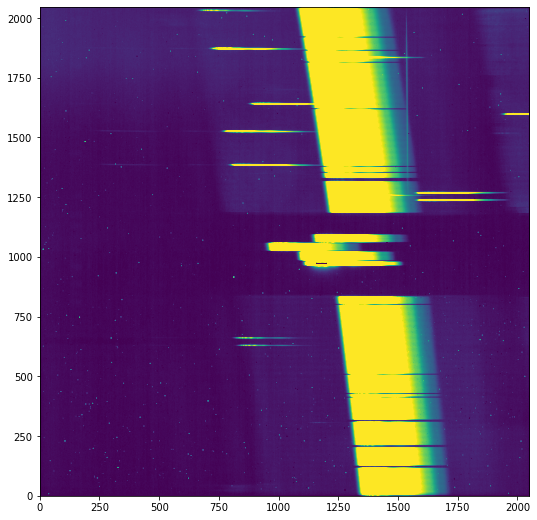

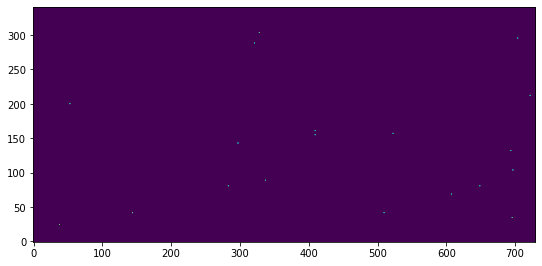

2021-01-22 17:01:57,049 - stpipe.AssignWcsStep - INFO - AssignWcsStep instance created.
2021-01-22 17:01:57,064 - stpipe.AssignWcsStep - INFO - AssignWcsStep instance created.
2021-01-22 17:01:57,203 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep running with args (<ImageModel(2048, 2048) from mos_prism_nrs1_uncal.fits>,).
2021-01-22 17:01:57,205 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.45, 'slit_y_high': 0.45}
2021-01-22 17:01:57,249 - stpipe.AssignWcsStep - INFO - Retrieving open MSA slitlets for msa_metadata_id = 1 and dither_index = 1
2021-01-22 17:0

NoDataOnDetectorError: No open slits fall on detector NRS1.

In [5]:
# Set common NPTT switches for this test

# accepted threshold difference with respect to benchmark files
msa_flagging_threshold = 99.5

# other NPTT variables
stellarity = None
operability_ref = None
source_type = None
save_figs = False
show_figs = True
debug = False

# Get the data
results_dict = {}
detectors = ['nrs1', 'nrs2']
for mode_config, data_set_dict in testing_data.items():
    for det in detectors:
        print('Testing files for detector: ', det)
        data = get_artifactory_file(data_set_dict, det)
        uncal_file, msa_shutter_config = data
        print('Working with uncal_file: ', uncal_file)
        uncal_basename = os.path.basename(uncal_file)
        
        # Make sure there is a local copy of the MSA shutter configuration file
        if msa_shutter_config is not None:
            subprocess.run(['cp', msa_shutter_config , '.'])
        
        # Run the stage 1 pipeline 
        rate_object = Detector1Pipeline.call(uncal_file)
        # Make sure the MSA shutter configuration file is set up correctly
        if msa_shutter_config is not None:
            msa_metadata = rate_object.meta.instrument.msa_metadata_file
            print(msa_metadata)
            if msa_metadata is None or msa_metadata == 'N/A':
                rate_object.meta.instrument.msa_metadata_file = msa_shutter_config

        # Run the stage 2 pipeline steps
        try:
            pipe_object = AssignWcsStep.call(rate_object)
        except:
            print('A stage 2 pipeline error occured, continuing the test. \n')
            continue
        msa_flagging_object = MSAFlagOpenStep.call(pipe_object)
        
        # Run the validation test
        %matplotlib inline
        
        result, result_msg, log_msgs = nptt.calwebb_spec2_pytests.auxiliary_code.msa_flagging_testing.run_msa_flagging_testing(
                                                                    msa_flagging_object, 
                                                                    msa_flagging_threshold = msa_flagging_threshold,
                                                                    rate_obj = rate_object,
                                                                    stellarity = stellarity, 
                                                                    operability_ref = operability_ref, 
                                                                    save_figs = save_figs, 
                                                                    show_figs = show_figs, 
                                                                    source_type = source_type, 
                                                                    debug = debug)

        # Remove non-notebook files from the repo directory
        local_fits_files = glob('./*.fits')
        for fits_file in local_fits_files:
            try:
                subprocess.run(['rm', fits_file])
            except FileNotFound:
                print('Fits file does not exist in current working directory: ', fits_file)
                
        local_json_files = glob('./*.json')
        for lfile in local_json_files:
            try:
                subprocess.run(['rm', lfile])
            except FileNotFound:
                print('File does not exist in current working directory: ', lfile)

        # Did the test passed 
        print("Did msa_flagging validation test passed? ", result_msg, "\n\n")
        rd = {mode_config: result_msg}
        results_dict.update(rd)


In [ ]:
# Quickly see if the test passed 

print('These are the final results of the tests: ')
for key, val in results_dict.items():
    print(key, val)


<a id="about_ID"></a>
## About this Notebook
**Authors:** 
- Emily Wislowski, Science Support Analyst I, NIRSpec
- Maria A. Pena-Guerrero, Staff Scientist II - Systems Science Support, NIRSpec

<br>**Updated On:** Jan/22/2021

[Top of Page](#title_ID)
<img style="float: right;" src="./stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="stsci_pri_combo_mark_horizonal_white_bkgd" width="200px"/> 